In [1]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout,Conv2DTranspose
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt
from random import randint
import sys, gc, time, shutil, os

import numpy as np

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
class DCGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 64
        self.img_cols = 64
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100
        self.PATH = 'lsun/church_outdoor_train_lmdb/church_outdoor_train_lmdb_color_64.npy'
        self.SAMPLE_SIZE = 0.1
        optimizer = Adam(0.0002, 0.5)
        
#       Remove the existing with old data and create new deirectory
        self.output_dir = 'output'        
        if os.path.exists(self.output_dir):
            shutil.rmtree(self.output_dir)        
            os.mkdir(self.output_dir)
        
        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(1,1,self.latent_dim))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):
        generator = Sequential()

        generator.add(Dense(units=4 * 4 * 512, kernel_initializer='glorot_uniform', input_shape=(1, 1, self.latent_dim)))
        generator.add(Reshape(target_shape=(4, 4, 512)))
        generator.add(BatchNormalization(momentum=0.5))
        generator.add(Activation('relu'))

        generator.add(Conv2DTranspose(filters=256, kernel_size=(5, 5),
                                  strides=(2, 2), padding='same',
                                  data_format='channels_last',
                                  kernel_initializer='glorot_uniform'))
        generator.add(BatchNormalization(momentum=0.5))
        generator.add(Activation('relu'))

        generator.add(Conv2DTranspose(filters=128, kernel_size=(5, 5),
                                  strides=(2, 2), padding='same',
                                  data_format='channels_last',
                                  kernel_initializer='glorot_uniform'))
        generator.add(BatchNormalization(momentum=0.5))
        generator.add(Activation('relu'))

        generator.add(Conv2DTranspose(filters=64, kernel_size=(5, 5),
                                  strides=(2, 2), padding='same',
                                  data_format='channels_last',
                                  kernel_initializer='glorot_uniform'))
        generator.add(BatchNormalization(momentum=0.5))
        generator.add(Activation('relu'))

        generator.add(Conv2DTranspose(filters=3, kernel_size=(5, 5),
                                  strides=(2, 2), padding='same',
                                  data_format='channels_last',
                                  kernel_initializer='glorot_uniform'))
        generator.add(Activation('tanh'))
      
        print('generator summary')
        generator.summary()
        return generator



    def build_discriminator(self):

        discriminator = Sequential()
        discriminator.add(Conv2D(filters=64, kernel_size=(5, 5),
                                 strides=(2, 2), padding='same',
                                 data_format='channels_last',
                                 kernel_initializer='glorot_uniform',
                                 input_shape=(self.img_shape)))
        discriminator.add(LeakyReLU(0.2))

        discriminator.add(Conv2D(filters=128, kernel_size=(5, 5),
                                 strides=(2, 2), padding='same',
                                 data_format='channels_last',
                                 kernel_initializer='glorot_uniform'))
        discriminator.add(BatchNormalization(momentum=0.5))
        discriminator.add(LeakyReLU(0.2))

        discriminator.add(Conv2D(filters=256, kernel_size=(5, 5),
                                 strides=(2, 2), padding='same',
                                 data_format='channels_last',
                                 kernel_initializer='glorot_uniform'))
        discriminator.add(BatchNormalization(momentum=0.5))
        discriminator.add(LeakyReLU(0.2))

        discriminator.add(Conv2D(filters=512, kernel_size=(5, 5),
                                 strides=(2, 2), padding='same',
                                 data_format='channels_last',
                                 kernel_initializer='glorot_uniform'))
        discriminator.add(BatchNormalization(momentum=0.5))
        discriminator.add(LeakyReLU(0.2))

        discriminator.add(Flatten())
        discriminator.add(Dense(1))
        discriminator.add(Activation('sigmoid'))
        
        
        print('discriminator summary')
        discriminator.summary()
        return discriminator

        

        

    def train(self, epochs, batch_size=128, save_interval= 50):
        g_losses = []
        d_losses = []

        # Load the dataset with image size 128 128 3
        X_train = self.load_npy(npy_path= self.PATH, amount_of_data= self.SAMPLE_SIZE)
        print("Train Shape{}:Sample Images shown below".format(X_train.shape))
        self.display_random_images(X_train)

        #Number of batches = number of images dvided by bath_size 
        number_of_batches = int(X_train.shape[0] / batch_size)
        print('Number of batches', number_of_batches, 'Batch Size', batch_size)
        
        
        for epoch in range(epochs):
            start_time = time.time() 
            starting_idx = 0
            print("Epoch {} of {}".format(epoch+1, epochs))
            for batch_number in range(number_of_batches):                              
                
                real_images = X_train[starting_idx: starting_idx + batch_size]
                starting_idx +=  batch_size
                
#               The actual batch size is given by the number of samples in data as the last batch will have less number
#               of images than batch_size
                current_batch_size = real_images.shape[0]

        
#               Generate noise of shape (current_batcg size, 1, 1 , 100)
                noise = np.random.normal(0, 1, size=(current_batch_size,) + (1, 1, self.latent_dim))
    
#               Generate Fake images
                generated_images = self.generator.predict(noise)
    
#               Add some noise to the labels that will be fed to the discriminator
#               real_y will have random values from 0.8 to 1 and fake_y will have random values from 0 to 0.2
                real_y = (np.ones(current_batch_size) - np.random.random_sample(current_batch_size) * 0.2)
                fake_y = np.random.random_sample(current_batch_size) * 0.2
                
#                Discrimnator is trained in real and fake images
                self.discriminator.trainable = True
                d_loss_real = self.discriminator.train_on_batch(real_images, real_y)
                d_loss_fake = self.discriminator.train_on_batch(generated_images, fake_y)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
                
                
#               Train the generator such that the fake samples generated as passed as Real to discriminator. Goal is to
#               let discriminator evaluate the fake images as real while weights are not updated at the same time
                self.discriminator.trainable = False
                noise = np.random.normal(0, 1, size=(current_batch_size * 2,) +  (1, 1, self.latent_dim))
#               Fake labels are passed as real
                fake_y = (np.ones(current_batch_size * 2) - np.random.random_sample(current_batch_size * 2) * 0.2)
                g_loss = self.combined.train_on_batch(noise, fake_y)       
               
                
#           Plot the progress after every epoch
            d_losses.append(d_loss[0])
            g_losses.append(g_loss)
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch+1, d_loss[0], 100*d_loss[1], g_loss))
            print('Time Elapsed {:0.2f}'.format(time.time() - start_time))
            self.save_imgs(epoch)
            
            
#           Display Imgaes and Grapth every 10 Epochs
            if  (epoch+1) % save_interval == 0:
               self.save_imgs(epoch, show_fig = True)
               self.display_losses(epoch, d_losses, g_losses)
             


    def save_imgs(self, epoch, show_fig = False):
        r, c = 5, 5
#         noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        noise = np.random.normal(0, 1, size=(r*c,) +  (1, 1, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 256        
        gen_imgs = (255*(gen_imgs - np.min(gen_imgs))/np.ptp(gen_imgs)).astype(int)
        
        plt.figure(figsize=(8,8))       

        for i in range(r*c):            
            plt.subplot(r, c, i+1)
            plt.imshow(gen_imgs[i, :,:,:])
            plt.axis('off')
        
        if show_fig:
            plt.show()
        else: 

            filename = "image_%d.png" % epoch
            plt.savefig(os.path.join(self.output_dir,filename ))
        plt.close()
        
    def display_losses(self,epoch, d_loss, g_loss):    
        epochs = list(range(0, epoch + 1))
        plt.figure(figsize = (12, 6))
        plt.ylim(0,3)
        plt.plot(epochs,  d_loss, color = 'red', label = 'Discriminator Loss')
        plt.plot(epochs , g_loss, color = 'blue', label = 'Generator Loss')        
        plt.legend()
        plt.show()

    def load_npy(self,npy_path, amount_of_data= 0.25):
        X_train = np.load(npy_path)
        X_train = X_train[:int(amount_of_data*float (len(X_train)))]
        X_train = (X_train.astype(np.float32) -127.5)/127.5     
        return X_train
    
    def display_random_images(self, X_train):
        plt.figure(figsize=(12,12))
        for i in range(64):
            plt.subplot(8,8,i+1)
            random_idx = randint(0, X_train.shape[0] -1)
            image = X_train[random_idx,:,:,:]
             # Rescale images 0 - 256        
            image = (255*(image - np.min(image))/np.ptp(image)).astype(int)
            plt.imshow(image)
        plt.show()

discriminator summary
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        4864      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 256)         819456    
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 8, 256)        

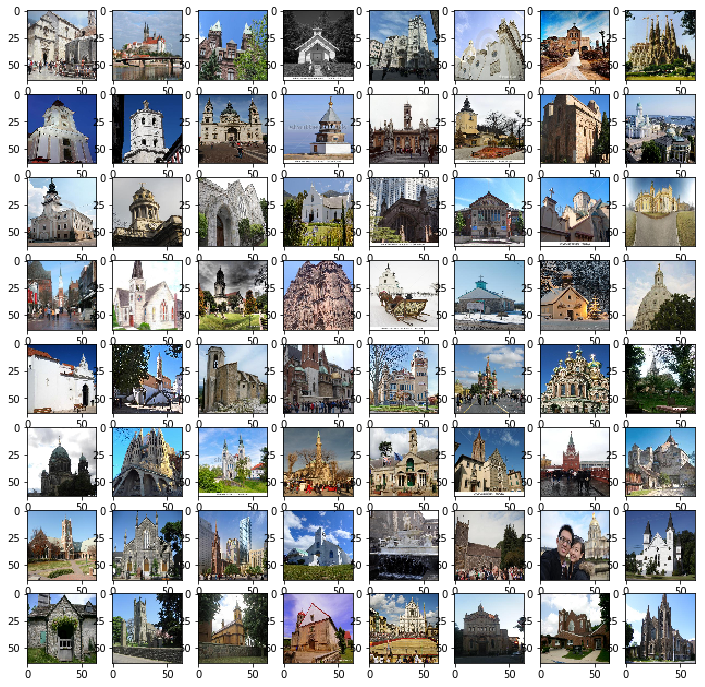

Number of batches 394 Batch Size 32
Epoch 1 of 1000
1 [D loss: 0.506295, acc.: 0.00%] [G loss: 1.948748]
Time Elapsed103.51
Epoch 2 of 1000
2 [D loss: 0.558788, acc.: 0.00%] [G loss: 2.597117]
Time Elapsed96.86
Epoch 3 of 1000
3 [D loss: 0.628181, acc.: 0.00%] [G loss: 1.861709]
Time Elapsed96.69
Epoch 4 of 1000
4 [D loss: 0.583401, acc.: 0.00%] [G loss: 2.158481]
Time Elapsed96.94
Epoch 5 of 1000
5 [D loss: 0.497159, acc.: 0.00%] [G loss: 2.282445]
Time Elapsed96.96
Epoch 6 of 1000
6 [D loss: 0.594886, acc.: 0.00%] [G loss: 3.013361]
Time Elapsed97.16
Epoch 7 of 1000
7 [D loss: 0.748879, acc.: 0.00%] [G loss: 4.182428]
Time Elapsed96.85
Epoch 8 of 1000
8 [D loss: 0.686964, acc.: 0.00%] [G loss: 2.991420]
Time Elapsed96.62
Epoch 9 of 1000
9 [D loss: 0.467886, acc.: 0.00%] [G loss: 2.606913]
Time Elapsed96.64
Epoch 10 of 1000
10 [D loss: 0.596223, acc.: 0.00%] [G loss: 3.043031]
Time Elapsed96.58


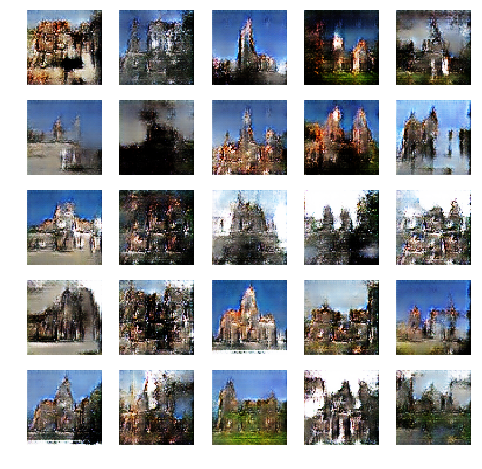

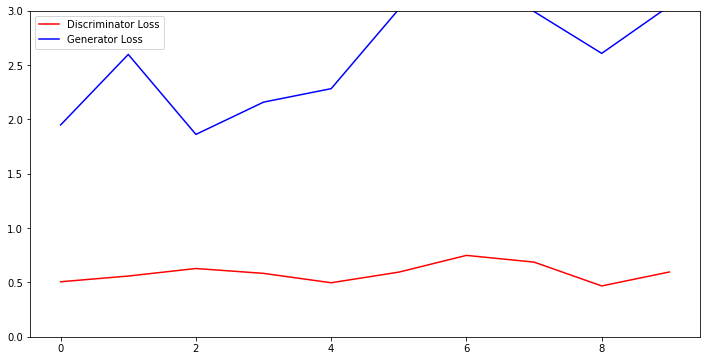

Epoch 11 of 1000
11 [D loss: 0.438647, acc.: 0.00%] [G loss: 1.734152]
Time Elapsed96.48
Epoch 12 of 1000
12 [D loss: 0.387328, acc.: 0.00%] [G loss: 2.435914]
Time Elapsed96.66
Epoch 13 of 1000
13 [D loss: 0.335051, acc.: 0.00%] [G loss: 1.563561]
Time Elapsed96.91
Epoch 14 of 1000
14 [D loss: 0.427764, acc.: 0.00%] [G loss: 1.786148]
Time Elapsed96.89
Epoch 15 of 1000
15 [D loss: 0.415950, acc.: 0.00%] [G loss: 2.195987]
Time Elapsed96.84
Epoch 16 of 1000
16 [D loss: 0.437039, acc.: 0.00%] [G loss: 2.435353]
Time Elapsed96.74
Epoch 17 of 1000
17 [D loss: 0.349201, acc.: 0.00%] [G loss: 1.452087]
Time Elapsed96.91
Epoch 18 of 1000
18 [D loss: 0.450073, acc.: 0.00%] [G loss: 2.121591]
Time Elapsed96.92
Epoch 19 of 1000
19 [D loss: 0.386873, acc.: 0.00%] [G loss: 2.058957]
Time Elapsed96.57
Epoch 20 of 1000
20 [D loss: 0.444934, acc.: 0.00%] [G loss: 1.874043]
Time Elapsed96.51


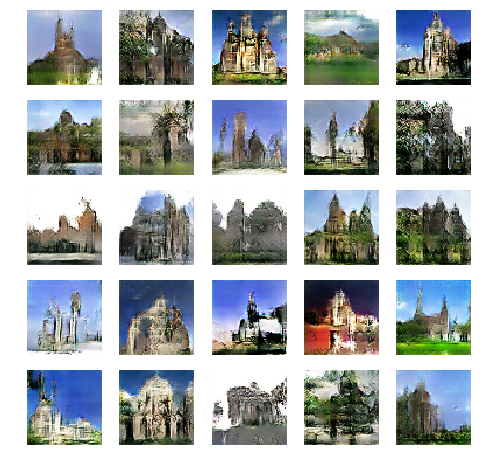

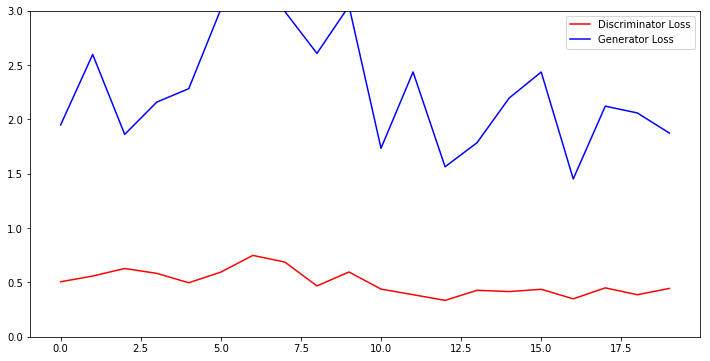

Epoch 21 of 1000
21 [D loss: 0.434006, acc.: 0.00%] [G loss: 1.843998]
Time Elapsed96.54
Epoch 22 of 1000
22 [D loss: 0.423554, acc.: 0.00%] [G loss: 2.178782]
Time Elapsed96.55
Epoch 23 of 1000
23 [D loss: 0.417228, acc.: 0.00%] [G loss: 2.976085]
Time Elapsed96.41
Epoch 24 of 1000
24 [D loss: 0.411910, acc.: 0.00%] [G loss: 1.629760]
Time Elapsed96.49
Epoch 25 of 1000
25 [D loss: 0.445797, acc.: 0.00%] [G loss: 3.010032]
Time Elapsed96.59
Epoch 26 of 1000
26 [D loss: 0.385579, acc.: 0.00%] [G loss: 2.228980]
Time Elapsed96.48
Epoch 27 of 1000
27 [D loss: 0.385009, acc.: 0.00%] [G loss: 2.517917]
Time Elapsed96.63
Epoch 28 of 1000
28 [D loss: 0.387433, acc.: 0.00%] [G loss: 3.034561]
Time Elapsed96.58
Epoch 29 of 1000
29 [D loss: 0.491634, acc.: 0.00%] [G loss: 2.478287]
Time Elapsed96.63
Epoch 30 of 1000
30 [D loss: 0.386069, acc.: 0.00%] [G loss: 1.635865]
Time Elapsed96.78


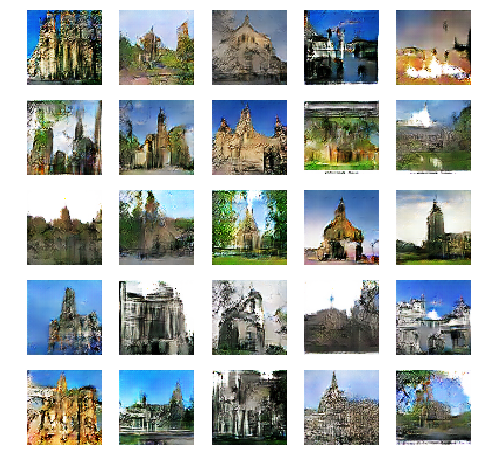

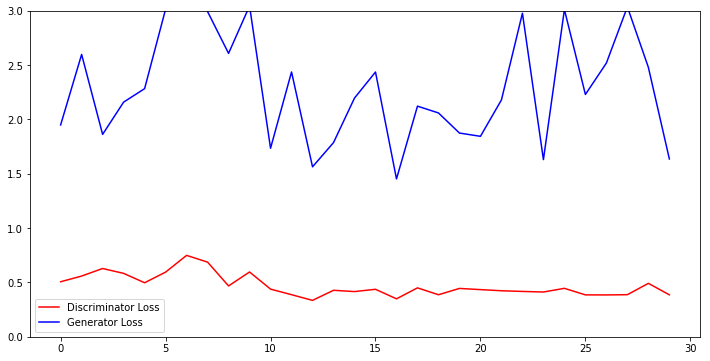

Epoch 31 of 1000
31 [D loss: 0.416718, acc.: 0.00%] [G loss: 2.635048]
Time Elapsed96.66
Epoch 32 of 1000
32 [D loss: 0.389571, acc.: 0.00%] [G loss: 2.501771]
Time Elapsed96.39
Epoch 33 of 1000
33 [D loss: 0.457760, acc.: 0.00%] [G loss: 3.529709]
Time Elapsed96.45
Epoch 34 of 1000
34 [D loss: 0.499287, acc.: 0.00%] [G loss: 1.742187]
Time Elapsed96.44
Epoch 35 of 1000
35 [D loss: 0.369653, acc.: 0.00%] [G loss: 2.408878]
Time Elapsed96.48
Epoch 36 of 1000
36 [D loss: 0.556738, acc.: 0.00%] [G loss: 3.031804]
Time Elapsed96.45
Epoch 37 of 1000
37 [D loss: 0.410852, acc.: 0.00%] [G loss: 2.293069]
Time Elapsed96.45
Epoch 38 of 1000
38 [D loss: 0.403922, acc.: 0.00%] [G loss: 2.884933]
Time Elapsed96.37
Epoch 39 of 1000
39 [D loss: 0.431153, acc.: 0.00%] [G loss: 3.066314]
Time Elapsed96.45
Epoch 40 of 1000
40 [D loss: 0.463241, acc.: 0.00%] [G loss: 2.735062]
Time Elapsed96.38


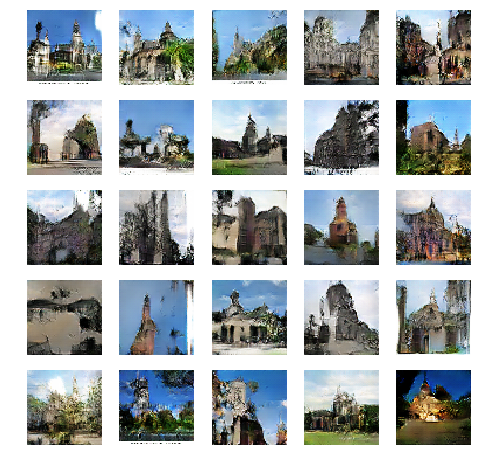

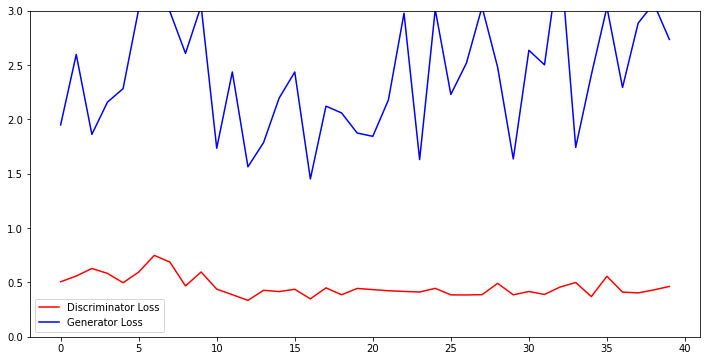

Epoch 41 of 1000
41 [D loss: 0.389101, acc.: 0.00%] [G loss: 3.337740]
Time Elapsed96.47
Epoch 42 of 1000
42 [D loss: 0.746794, acc.: 0.00%] [G loss: 1.608748]
Time Elapsed96.54
Epoch 43 of 1000
43 [D loss: 0.360549, acc.: 0.00%] [G loss: 2.387317]
Time Elapsed96.55
Epoch 44 of 1000
44 [D loss: 0.386927, acc.: 0.00%] [G loss: 2.621532]
Time Elapsed96.48
Epoch 45 of 1000
45 [D loss: 0.401675, acc.: 0.00%] [G loss: 2.203740]
Time Elapsed96.42
Epoch 46 of 1000
46 [D loss: 0.343699, acc.: 0.00%] [G loss: 2.632914]
Time Elapsed96.22
Epoch 47 of 1000
47 [D loss: 0.367667, acc.: 0.00%] [G loss: 2.959063]
Time Elapsed96.34
Epoch 48 of 1000
48 [D loss: 0.371049, acc.: 0.00%] [G loss: 1.824264]
Time Elapsed96.26
Epoch 49 of 1000
49 [D loss: 0.366184, acc.: 0.00%] [G loss: 2.070274]
Time Elapsed96.24
Epoch 50 of 1000
50 [D loss: 0.678313, acc.: 0.00%] [G loss: 2.724994]
Time Elapsed96.28


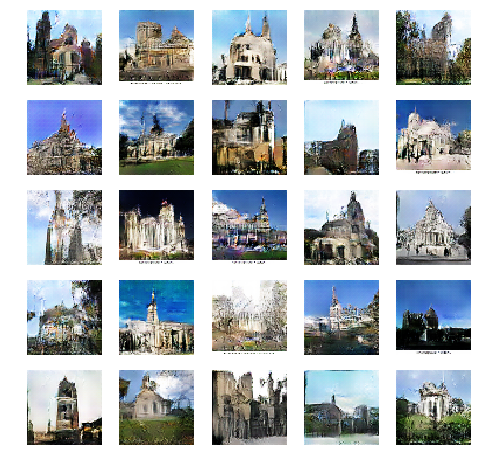

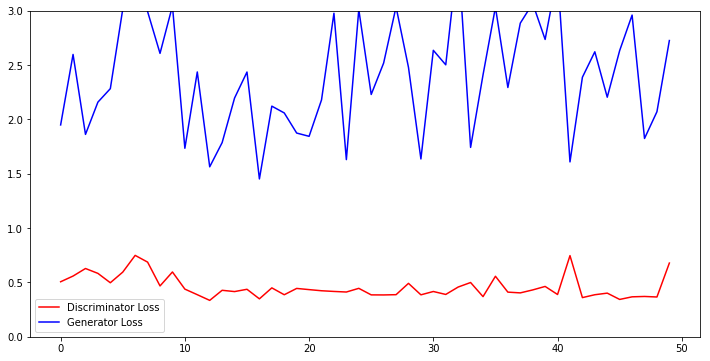

Epoch 51 of 1000
51 [D loss: 0.378773, acc.: 0.00%] [G loss: 2.278166]
Time Elapsed96.32
Epoch 52 of 1000
52 [D loss: 0.374759, acc.: 0.00%] [G loss: 3.057296]
Time Elapsed96.24
Epoch 53 of 1000
53 [D loss: 0.359728, acc.: 0.00%] [G loss: 2.151887]
Time Elapsed96.65
Epoch 54 of 1000
54 [D loss: 0.372570, acc.: 0.00%] [G loss: 2.523659]
Time Elapsed96.68
Epoch 55 of 1000
55 [D loss: 0.330576, acc.: 0.00%] [G loss: 2.506882]
Time Elapsed96.64
Epoch 56 of 1000
56 [D loss: 0.403378, acc.: 0.00%] [G loss: 2.971573]
Time Elapsed96.74
Epoch 57 of 1000
57 [D loss: 0.370824, acc.: 0.00%] [G loss: 1.571300]
Time Elapsed96.74
Epoch 58 of 1000
58 [D loss: 0.420136, acc.: 0.00%] [G loss: 2.490649]
Time Elapsed96.66
Epoch 59 of 1000
59 [D loss: 0.408349, acc.: 0.00%] [G loss: 3.108701]
Time Elapsed96.68
Epoch 60 of 1000
60 [D loss: 0.510860, acc.: 0.00%] [G loss: 2.249021]
Time Elapsed96.22


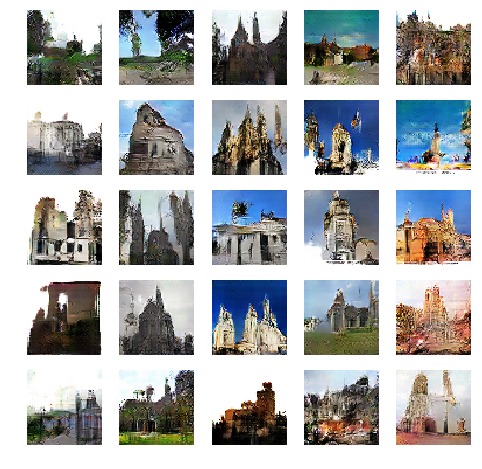

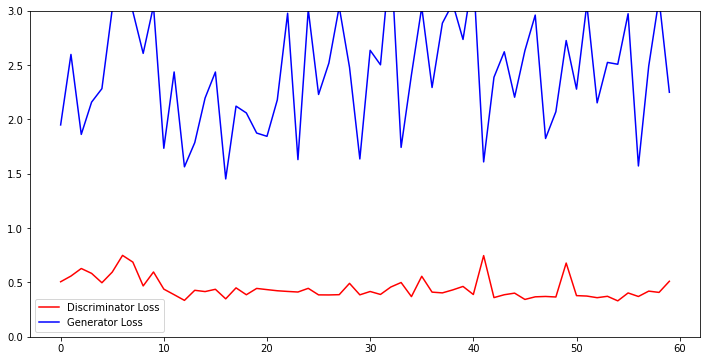

Epoch 61 of 1000


In [ ]:
if __name__ == '__main__':
    dcgan = DCGAN()
    dcgan.train(epochs=1000, batch_size= 32, save_interval= 10)